## LROSE EXAMPLES ERAD 2022

**Realtime CWB image. User-defined azimuth and range.**

* **This notebook pulls the CWB latest radar image from https://www.cwb.gov.tw/V8/C/W/OBS_Radar.html, and plot the scan azimuths from the planned S-Pol (Hsin-Chu) and SEA-POL (Yonaguni Isl.) radar locations.**

* **How to run?**
    1. Choose the radars (S-Pol at Hsin-Chu or SEA-POL at Yonaguni, or both)
    2. Specify the list of the scan azimuths and ranges.
    3. Check out the output figure of the scans.
    4. Repeat 2–3 to make final decision for the scan strategy.


In [1]:
# %reset

In [96]:
import datetime
import pytz
import math
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
from pyproj import Geod
import netCDF4 as nc
import xarray as xr
import pyart

import warnings
warnings.filterwarnings('ignore')

filePath = '/data/spol/lrose_workshop/mosaic_3d/20220608/20220608_120000.mdv.cf.nc'

## Read in radar mosaic from CF-netCDF.

In [18]:
ds = nc.Dataset(filePath)
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: This MDV file was created by CwbRadar2Mdv.
    source: RCWF RCHL RCCG RCKT RCCK ISHI RCGI RCLY RCNT RCSL 
    title: 3D radar data mosaic from Taiwan CWB.
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(441), y0(561), z0(21)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int16 DBZ(time, z0, y0, x0)
    groups: 


In [175]:
uTimeSecs = ds['start_time'][0]
startTime = datetime.datetime.fromtimestamp(int(uTimeSecs))
startTimeStr = startTime.strftime('%Y/%m/%d-%H:%M:%S UTC')
print(startTimeStr)

2022/06/08-12:00:00 UTC


In [166]:
print(ds['DBZ'])
fillValue = ds['DBZ']._FillValue
print(fillValue)

<class 'netCDF4._netCDF4.Variable'>
int16 DBZ(time, z0, y0, x0)
    scale_factor: 0.002
    add_offset: 44.992004
    valid_min: -32767
    valid_max: 32767
    _FillValue: -32768
    min_value: -20.5
    max_value: 63.800003
    standard_name: DBZ
    long_name: mosaicked refl
    units: dbz  
    grid_mapping_name: latitude_longitude
    mdv_field_code: 256
    mdv_user_time_1: 0
    mdv_user_time_2: 0
    mdv_user_time_3: 0
    mdv_user_time_4: 0
    mdv_user_data_si32_0: 0
    mdv_user_data_si32_1: 0
    mdv_user_data_si32_2: 0
    mdv_user_data_si32_3: 0
    mdv_user_data_si32_4: 0
    mdv_user_data_si32_5: 0
    mdv_user_data_si32_6: 0
    mdv_user_data_si32_7: 0
    mdv_user_data_si32_8: 0
    mdv_user_data_si32_9: 0
    mdv_user_data_fl32_0: 0.0
    mdv_user_data_fl32_1: 0.0
    mdv_user_data_fl32_2: 0.0
    mdv_user_data_fl32_3: 0.0
    mdv_proj_type: 0
    mdv_proj_origin_lat: 0.0
    mdv_proj_origin_lon: 0.0
    mdv_transform_type: 0
    mdv_vlevel_type: 4
    mdv_native_vle

In [167]:
dbz1 = np.array(ds['DBZ'])
print(dbz1.size)
print(dbz1.shape)
print(dbz1.ndim)
print(dbz1[0][0][256][0])

5195421
(1, 21, 561, 441)
4
-32768.0


In [168]:
lon = np.array(ds['x0'])
lat = np.array(ds['y0'])
dLon = lon[1] - lon[0]
dLat = lat[1] - lat[0]
minLon = lon[0] - dLon / 2.0
maxLon = lon[-1] + dLon / 2.0
minLat = lat[0] - dLat / 2.0
maxLat = lat[-1] + dLat / 2.0

In [169]:
dbzPlane0 = dbz1[0][0:1]
print(dbzPlane0.shape[0])
print(dbzPlane0.shape[1])
print(dbzPlane0.shape[2])
dbz2D = dbzPlane0.reshape(dbzPlane0.shape[1],dbzPlane0.shape[2])
print(dbz2D.shape)
print(dbz2D[dbz2D != fillValue])

1
561
441
(561, 441)
[23.000004 19.000004 37.000004 ... 26.500004 28.500004 22.000004]


In [170]:
dbzPlaneMax = np.amax(dbz1, (0, 1))
dbzPlaneMax[dbzPlaneMax == fillValue] = np.nan
print(dbzPlaneMax.shape)
print(dbzPlaneMax[dbzPlaneMax != fillValue])
print(np.min(dbzPlaneMax))
print(np.max(dbzPlaneMax))

(561, 441)
[      nan       nan       nan ... 23.000004 24.000004 25.000004]
nan
nan


In [188]:
def new_map(fig):
    
    ## Create projection centered as the CWB radar image:
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    
    ## Set extent the same as radar mosaic
    ax.set_extent([minLon, maxLon, minLat, maxLat])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'weight': 'bold'}
    
    return ax

Text(0.5, 1.0, 'Radar mosaic DBZ: 2022/06/08-12:00:00 UTC')

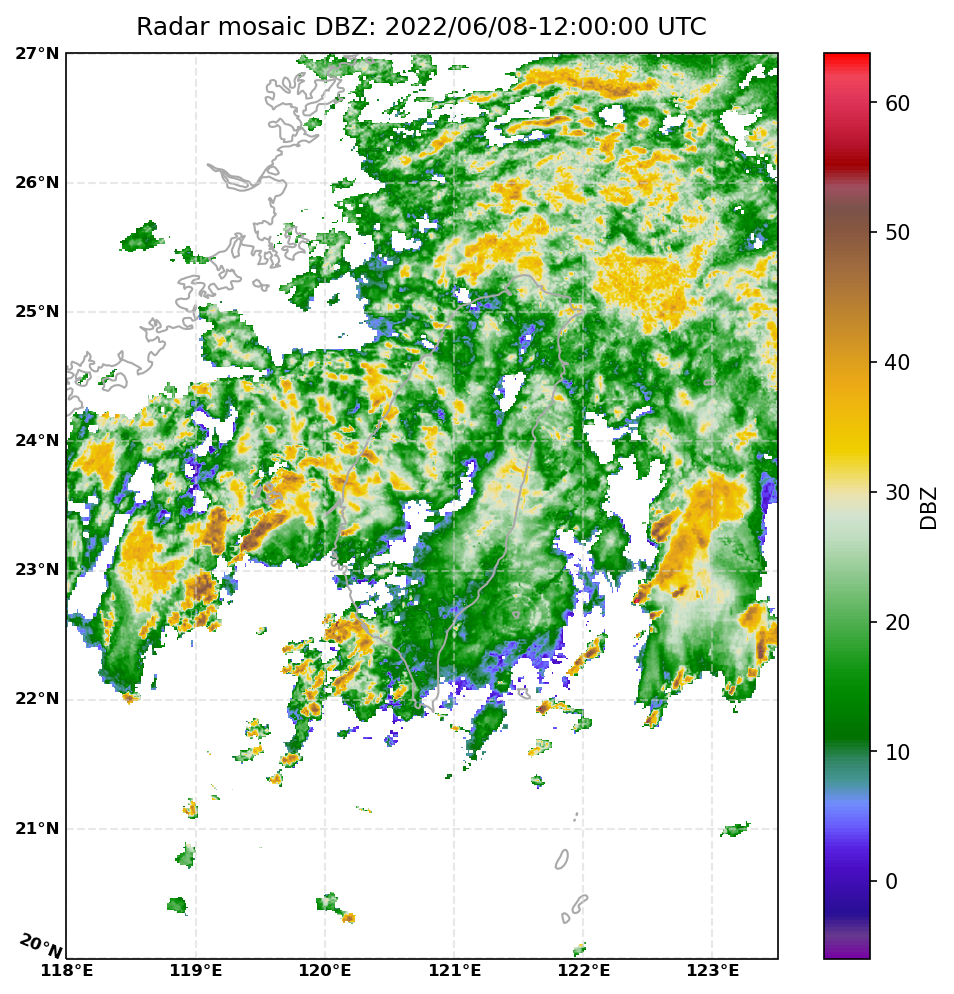

In [189]:
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = new_map(fig)
plt.imshow(dbzPlaneMax,
            cmap='pyart_Carbone42',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLon, maxLon, minLat, maxLat))
ax.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="DBZ", orientation="vertical")
plt.title("Radar mosaic DBZ: " + startTimeStr)

In [4]:
print(ds.__dict__['history'])

This MDV file was created by CwbRadar2Mdv.


In [5]:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'bounds', size = 2
<class 'netCDF4._netCDF4.Dimension'>: name = 'x0', size = 441
<class 'netCDF4._netCDF4.Dimension'>: name = 'y0', size = 561
<class 'netCDF4._netCDF4.Dimension'>: name = 'z0', size = 21


In [6]:
for var in ds.variables.values(): matplotlib.pyplot.figtext(x, y, s, fontdict=None, **kwargs)[source]
    print(var)
    print("========================================")

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: Data time
    units: seconds since 1970-01-01T00:00:00Z
    axis: T
    bounds: time_bounds
    comment: 2022-06-08T12:00:00Z
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 start_time(time)
    long_name: start_time
    units: seconds since 1970-01-01T00:00:00Z
    comment: 2022-06-08T12:00:00Z
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 stop_time(time)
    long_name: stop_time
    units: seconds since 1970-01-01T00:00:00Z
    comment: 2022-06-08T12:00:00Z
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 x0(x0)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    

#### Functions for time retrieving:

In [7]:
def timeround10(dt):
    # a, b = divmod(round(dt.minute, -1), 60)
    a, b = divmod(math.floor(dt.minute * 0.1)/0.1, 60)
    # return '%i:%02i' % ((dt.hour + a) % 24, b)
    print(b)
    return datetime.datetime(dt.year, dt.month, dt.day, int((dt.hour + a) % 24), int(b), 0, 0) 

def timeround10before(tm):
    tm = tm - datetime.timedelta(minutes=tm.minute % 10, seconds=tm.second, microseconds=tm.microsecond)
    return tm


#### Retrieve the latest radar image form CWB and generate one test plot:
* Choose between two different CWB map types ('L'arge area / 'C'oncentrate to Taiwan) \
and w/wo topography (wo:1 / w:2).
* The URL for of the latest radar image will be printed for checking.

In [8]:
map_type = 'C'
map_topo = '1'

if ( map_type == 'C' ):
    img_extent = (118, 124, 20.5, 26.5)
elif( map_type == 'L' ):
    img_extent = (115, 126.5, 17.75, 29.25)

def map_selection(map_type, map_topo):
    if ( map_type == 'C' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_TW_3600_'
    elif ( map_type == 'L' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_3600_'
    return radar_img_url_name
        
radar_img_url_name = map_selection(map_type, map_topo)
    
try:
    radar_img_time = timeround10before(datetime.datetime.now(pytz.timezone('Asia/Taipei'))).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)
except:
    print('Current time unavailable. Try 10-min before:')
    radar_time = datetime.datetime.now(pytz.timezone('Asia/Taipei')) - datetime.timedelta(minutes=10)
    radar_img_time = timeround10before(radar_time).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)

# plt.figure(figsize=(4, 4), dpi=150)
# plt.imshow(radar_img)
# plt.show()


https://www.cwb.gov.tw/Data/radar/CV1_TW_3600_202207311420.png


#### Function generating maps and azimuth rings:

In [7]:
def new_map(fig, sitename, azimuths_mand, azimuths_user, ranges):
    
    ## Radars locations (lon, lat, rhi range):
    radars_info = { 'SPOL': [120.908, 24.819, 150]#100]
                  , 'SEAPOL': [122.9439, 24.4572, 97]
                  }
    
    ## Create projection centered as the CWB radar image:
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ## Add coastlines:
    ax.coastlines('10m', 'lightgray', linewidth=1, zorder=0)
    
    ## Set extent the same as CWB radar image:
    if ( map_type == 'C' ):
        ax.set_extent([117.75, 124.25, 20.25, 26.75])
    elif ( map_type == 'L' ):
        ax.set_extent([114.75, 126.75, 17.5, 29.5])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     # , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    gl.ylines = False
    if ( map_type == 'L' ):
        gl.xlocator = plticker.FixedLocator(np.arange(115, 126.5, 1))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    ## Add the location of the radar:
    rloc = plt.plot( radars_info[sitename][0], radars_info[sitename][1]
                   , marker='s'
                   , markersize=7
                   , mec='none'
                   , mew=1
                   , mfc='r'
                   , linestyle='none'
                   , transform=ccrs.PlateCarree()
                   , zorder=10
                   , label=sitename
                   )

    ## Set geod:
    geod = Geod(ellps='WGS84')
    
    ## Add radar range rings:
    for rng_km in ranges:
        rrings = ax.tissot( rad_km=rng_km
                          , lons=radars_info[sitename][0]
                          , lats=radars_info[sitename][1]
                          , n_samples=180
                          , facecolor='none'
                          , edgecolor='r'
                          , linewidth=1.2
                          , linestyle='dotted'
                          , label='SUR ranges (km)'
                          )
        lon_r, lat_r, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], 0, rng_km*1e3)
        ax.text(lon_r, lat_r, rng_km, transform=ccrs.PlateCarree(), color='r')
    
    ## Line points at azimuths (mandatory):
    for az in azimuths_mand:
        lon2, lat2, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], az, radars_info[sitename][2]*1e3)
        sazi = ax.plot( [radars_info[sitename][0], lon2]
                      , [radars_info[sitename][1], lat2]
                      , ':k'
                      , transform=ccrs.PlateCarree()
                      , linewidth=0.8
                      , label='RHI azimuths (deg)'
                      )
        ax.text(lon2, lat2, az, transform=ccrs.PlateCarree())
        
    ## Line points at azimuths (user-defined):
    for az in azimuths_user:
        lon2, lat2, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], az, radars_info[sitename][2]*1e3)
        sazi = ax.plot( [radars_info[sitename][0], lon2]
                      , [radars_info[sitename][1], lat2]
                      , '-k'
                      , transform=ccrs.PlateCarree()
                      , linewidth=0.8
                      , label='RHI azimuths (deg)'
                      )
        ax.text(lon2, lat2, az, transform=ccrs.PlateCarree())
        
    # Set legend:
    legend_elements = [Line2D([0], [0], linestyle=':', color='k', lw=1, label='Mandatory'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='RHIuser')]
    plt.legend(handles=legend_elements, loc='center left', shadow=True)
    # plt.legend(loc='lower center'
    #           , shadow=True
    #           )
    
    return ax

***
#### <font color='red'>! Don't worry about the cells above !</font> unless you want to make some further edits.
***

### <font color='forestgreen'>User specifications from here:<font color='darkorange'>
### <font color='darkorange'>1. Choose the radars:</font>
**Keep the radar you want to make the figure and comment the other.**

In [8]:
the_radar = 'SPOL'
# the_radar = 'SEAPOL'
# the_radar = 'both'

### <font color='darkorange'>2. Specify the scans azimuth & ranges:</font>
**Specify the azimuth angles into the list, e.g. 0º for Noth. And scan ranges in [km].**

In [9]:
# Mandatory RHI scan angles (should not modify)
rhi_scan_mandatory = [101, 281, 90, 85, 75, 60, 45, 30, 0, 315, 270, 225, 183, 137]

# Range rings
scan_range = [25, 50, 100, 150]

**User-defined RHIs** [from Spol documentation in Ops Plan]

Can consider centering on specific locations of interest or wider coverage in a specific direction, for example:

- NCU: 3° azimuthal spacing over a 30° sector centered near NCU at 60° azimuth (angles = 42.0°, 45.0°,48.0°, 51.0°, 54.0°, 57.0°, 60.0°, 63.0°, 66.0°, 69.0°, 72.0°, 75.0°)
- TEAM-R: located at 29° azimuth
- full360: 15, 345, 330, 298, 255, 240, 211, 197, 168, 153, 125, 113
- North sector: 290, 300, 310, 320, 330, 340, 350, 10, 20, 37, 52, 67
- East sector: 10, 20, 37, 52, 67, 110, 120, 130, 145, 155, 165, 175
- South sector: 255, 240, 215, 205, 195, 175, 165, 155, 145, 130, 120, 110
- West sector: 350, 340, 330, 320, 310, 300, 290, 255, 240, 215, 205, 195
- Preset sectors: pre-set NE, NW, SE, and SW quadrants
- Problematic azimuthal angles to avoid: 29.0°, 135.0°, 180.0°, 70-74° (too close to Wufenshan radar/interference)
- Recommendation to order the RHIs so the end angle is the one closest to 101° (the start angle for mandatory RHI1) 


In [11]:
# Specify PrecipRhiUser

# Either using one of the standard sector setups:

RHIusername='360'

if RHIusername == 'initiation':
    rhi_scan_user = [211, 203, 195, 189, 177, 171, 125, 113, 107, 95, 80, 67.5]
elif RHIusername == '360':
    rhi_scan_user = [15, 345, 330, 298, 255, 240, 211, 197, 168, 153, 125, 113]
elif RHIusername == 'north':
    rhi_scan_user = [290, 300, 310, 320, 330, 340, 350, 10, 20, 37, 52, 67]
elif RHIusername == 'east':
    rhi_scan_user = [10, 20, 37, 52, 67, 110, 120, 130, 145, 155, 165, 175]
elif RHIusername == 'south':
    rhi_scan_user = [255, 240, 215, 205, 195, 175, 165, 155, 145, 130, 120, 110]
elif RHIusername == 'west':
    rhi_scan_user = [350, 340, 330, 320, 310, 300, 290, 255, 240, 215, 205, 195]
elif RHIusername == 'southwest':
    rhi_scan_user = [310, 300, 290, 255, 240, 215, 205, 195, 175, 165, 155, 145]
elif RHIusername == 'southeast':    
    rhi_scan_user = [215, 205, 195, 175, 165, 155, 145, 130, 120, 110, 67, 52]
elif RHIusername == 'northwest':   
    rhi_scan_user = [240, 255, 290, 300, 310, 320, 330, 340, 350, 10, 20, 37]
elif RHIusername == 'northeast': 
    rhi_scan_user = [320, 330, 340, 350, 10, 20, 37, 52, 67, 110, 120, 130]
elif RHIusername == 'custom': # when the strategy doesn't match any of the above
    rhi_scan_user = [205, 232, 250, 260, 340, 350, 10, 20, 37, 52, 110, 120] 
    

# Dummy checks
# Ensure we've picked 12 angles
if np.shape(rhi_scan_user)[0] != 12:
    print("Check number of angles!")
    print(np.shape(rhi_scan_user)[0])
# Avoid problematic angles
azim_avoid = [29,135,180]
for iaz in azim_avoid:
    if iaz in rhi_scan_user: print("STOP: check for bad azimuth!")
# Range from 70-74 must also be avoided
if np.any(np.logical_and(np.array(rhi_scan_user) >= 70, np.array(rhi_scan_user) <= 74)):
    print("STOP: check for bad azimuth!")

### <font color='darkorange'>3. Check out the figure:</font>
**The figure of desired radar scans will be generated here and saved as a png file under the same folder.**

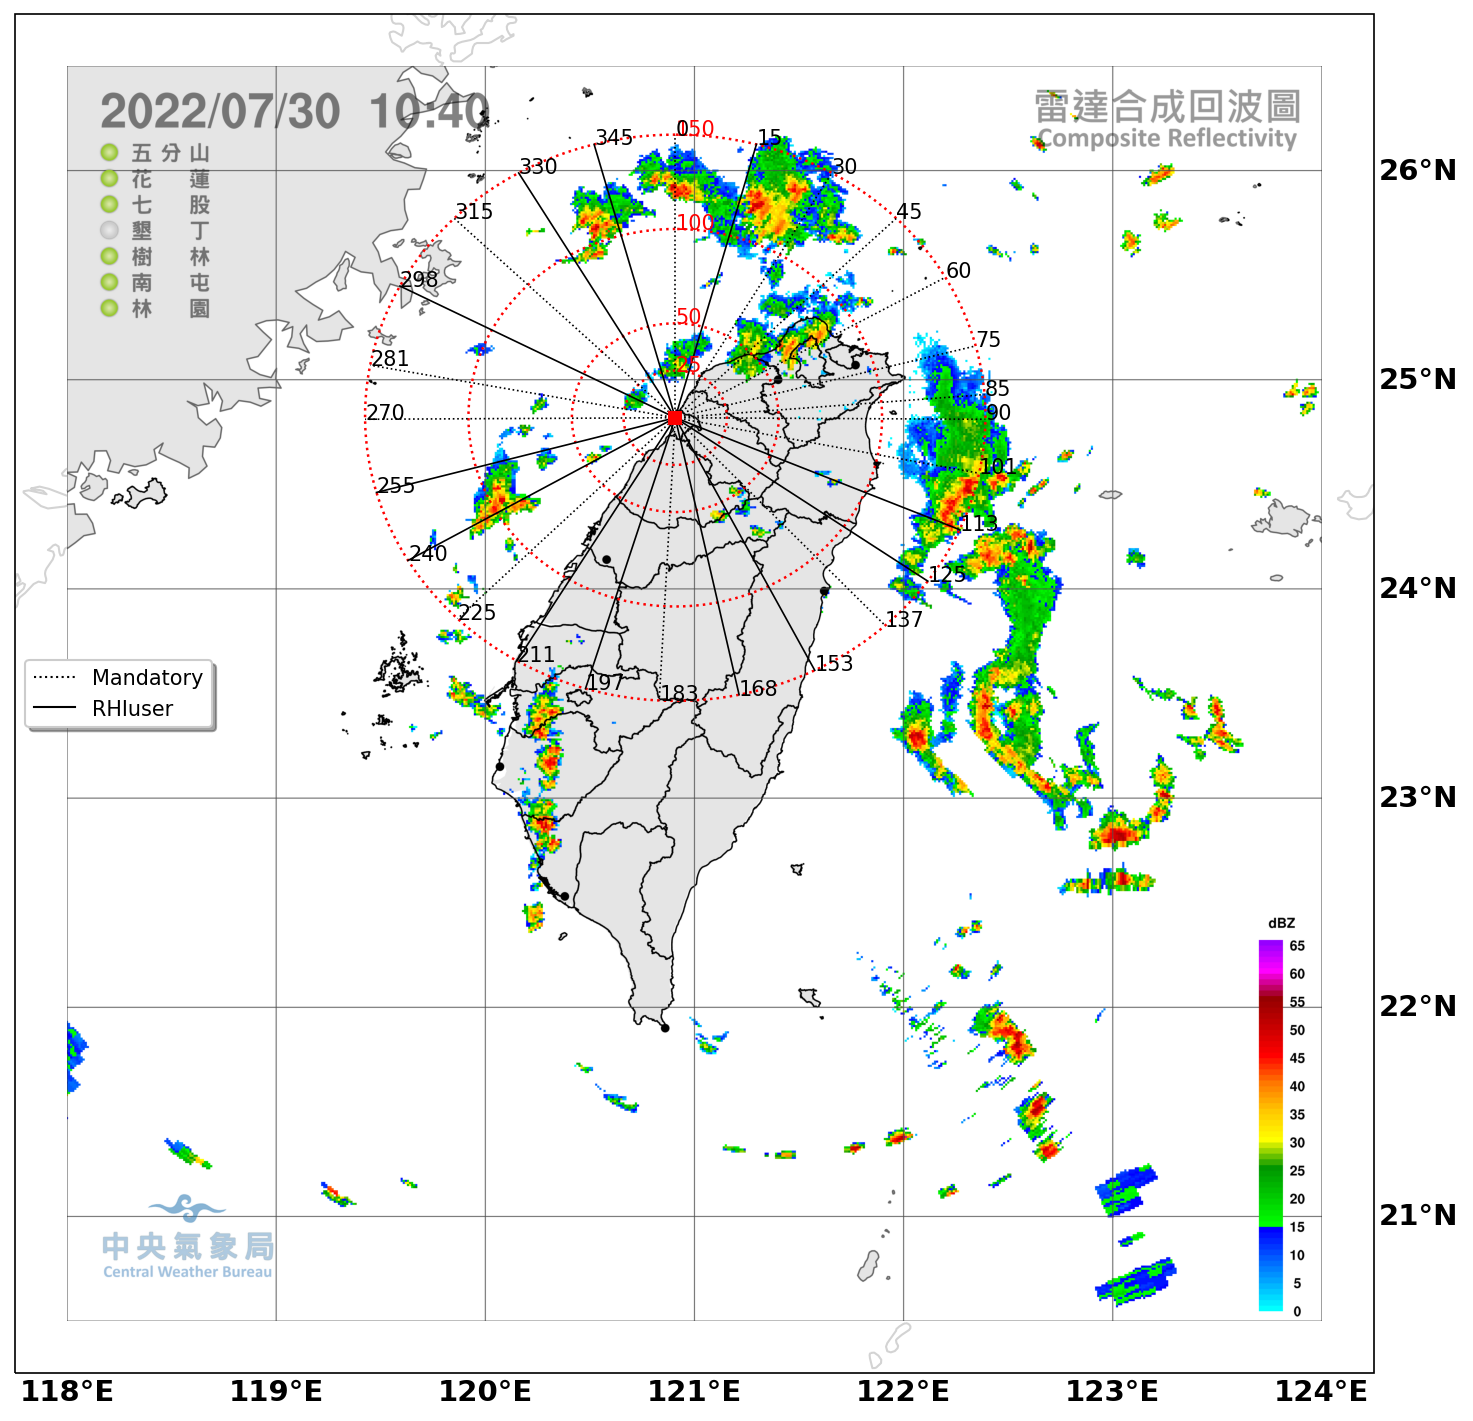

In [13]:
fig = plt.figure(figsize=(12, 12), dpi=150)

# ax = new_map(fig, the_radar, rhi_scans, scan_range)
ax = new_map(fig, the_radar, rhi_scan_mandatory, rhi_scan_user, scan_range)
plt.imshow(radar_img, extent=img_extent, zorder=0, transform=ccrs.PlateCarree())

# plt.savefig('./PRECIP2022_' + the_radar + '_scans_' + '20220730_0950LT.png', bbox_inches='tight', facecolor = 'white')